In [1]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
Pitt.Theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() +aes()+ Pitt.Theme

# Generalized Linear Models
The basic "how" for GLM estimates is what we've covered, where we attempt to maximize a likelihood. Generalized Linear Models are set up so that this is a relatively well-behaved optimization. The basic ingredients for a GLM model are:
* A family of distribution, where each family has a well-defined link between the mean and variance
* A specified linear in parameters model for the population mean, in the same way you would for a linear model
* A link function between the parameters and the central tendency

### GLM: Families of distribution

In order to have a well-defined link between the mean and variance that allows GLM models to be estimated quickly, we have to restrict ourselves to distributions that we can fit into a family of exponential-like probability distributions.

This family includes:
* Gaussian/Normal distributions (standard real-valued data)
* Exponential distribution (positive real values)
* Poisson distributions (count data)
* Binomial distributions (counts from a fixed and known $n$)
    * Special case is a Bernoulli random variable with $n=1$
* Multinomial distributions (factor outcomes)
* Gamma distributions (positive real values, includes $\chi^2$/exponential as special cases)
* Inverse Gaussian (positve real values, some use in finance)

### GLM: Parameter Model
The model we put into the GLM is identical to how you would formulate a standard linear model. 

Given an observable vector of $k$ conditioning variables $\mathbf{x}_i$ for each row $i$, the model specifies an effect of $\mathbf{x}_i^T\boldsymbol{\beta}$, with $\beta$ being a set of $k$ parameters we're going to estimate
* Note that we can include a constant within this formulation as per normal.

However, the $\mathbf{x}_i^T\boldsymbol{\beta}$ term won't necessarily be estimating the mean directly, this is where the link functions come in.

### GLM: Link Function
The **Link function** specifies how the mean of the outcome is related to the model. That is we specify is a transformation of the mean via an invertible link function $g(\cdot)$. 

So if the mean of the data is $\mu$ our model is trying to inform us about the world through $$\mathbf{x}_i^T\boldsymbol{\beta}=g(\mu)$$
and because the link function $g(\cdot)$ has to be invertible we can re-word this as saying that:
$$g^{-1}(\mathbf{x}_i^T\boldsymbol{\beta})=\mu$$

One thing to note here is that the distribution of the response variable $y_i$ is not being transformed with the link function: The chosen distribution of $y_i$ is given by the specified probability distribution (Poisson, Normal, Binomial, etc.)
* So if the link is the log function you are **not** modeling the effects on $\log(y)$
* You are instead modeling the effects on a transformation of the Expected outcome for the $y$ variable.

As an example, think back to our soccer model where we were estimating the parameter $\lambda_{ij}$ in a Poisson random variable, modeling of the goals scored by team $i$ playing against team $j$
*  If $K$ is a $\text{Poisson}(\lambda_{ij})$ random variable the mean is given by $\mathbb{E}(K)=\lambda_{ij}$.
*  But our model of the mean was: $\lambda_{ij} = \exp\left(\mu+ \eta+\alpha_i-\delta_j \right)$

So we were using the the natural logarithm as our link function. That is $g(\lambda)=\log(\lambda)=\mu_0+ \mu_{H}+\alpha_i-\delta_j$ which gave us our additive model.

Essentially, by writing the model in this way, we are essentially saying that each of the separate terms has a multiplicative effect, and each term has to be positive (because of the exponential):
$$\lambda = \exp\left(\mu_0+\mu_{H}+\alpha_i-\delta_j \right)=e^{\mu_0}e^{\mu_{H}}e^{\alpha_i}e^{-\delta_j}$$

While a lot of the relationships here are non-linear, the modeling choices allows us to write out how the input varaibles affect the mean in a standard linear form as $\mathbf{x}_i^T\boldsymbol{\beta}=\sum_k \beta_k x_{ik}$ where:
* $x_{1i}$ is a constant
* $x_{2i}$ is a dummy taking value 1 if the team is at home
* $x_{3i}$ is a dummy for team 2 being the team trying to score goals
* $x_{4i}$ is a dummy for team 2 being the team trying to defend goals, etc
* ...

So it would have been equivalent to estimate the multiplier effect from  being the home team $e^{\mu_H}=$ as a parameter $1.1571$ which has the more intuitive interpretation that being the home team increases the goals scored by a team by 15.7 percentage points!

However, writing things as additive with a simple linear model for the teams' offense and defensive abilities was easier to write down/estimate/combine, where we could quickly go between the estimated parameters of the model, and their effects on the mean via the exponential (the inverse of the natural-log link function).

### Common Link Functions:
Three commonly used link functions:
* The identity function (directly modeling the mean!) $g(\mu)=\mu$
* The log function (so modeling multiplicative effects on the mean) with $\log{\mu}$
* The logit function $\log(\frac{x}{1-x})$ (modeling the multiplicative effect on an odds ratio)

While less common in some settings, for probabilities we will also use the probit link function: $$\Phi^{-1}(p)$$
the inverse of a standard Normal CDF.

## Less-common Link Functions
We won't talk about this much these link functions but they are the typical ones for these applications:
* Inverse function $1/\mu$(typical for exponential distributions)
* Inverse function squared (used for inverse Gaussian)

## Standard Link functions
| Prob. family | Standard Link | Other Links |
| --- | --- | --- |
| Normal/Gaussian |  Identity: $\mu$  |    |
| Poisson   |  log: $\log(\mu$) |  Identity, square-root   |
| Binomial  |  logit:  $\log(\tfrac{\mu}{1-\mu})$  |   probit, cloglog  |
| Gamma     |  inverse: $\frac{1}{\mu}$ |   identity, log  |





## Notation for GLM
Standard notation for GLM (including within the R documentation) is:
* $\eta_i$ (eta) is the **linear predictor** for observation $i$,  $\eta_i=\mathbf{x}_i^T\boldsymbol{\beta}$
* So the fitted values will be the guess for the mean for row $i$ through the inverse of the link function, so $g^{-1}(\eta_i).$

### Example
Let's set up a Poisson model for the number of children in a household, where we will use $\lambda_i = \exp\left(\beta_0 +\beta_1 \delta_\text{married}+\beta_2 \log(\text{income})\right)=\exp(\eta_i)$

In [2]:
Ndata <- 1000
x1 <- ifelse(runif(Ndata)<0.5,0,1)
x2.0 <- rnorm(Ndata,mean=2.1,sd=0.8)
x2.1 <- rnorm(Ndata,mean=2.5,sd=0.9)
x2 <- ifelse(x1==1,x2.1,x2.0)
beta <- c( ) # Actual Beta vector 
lambda <- exp(beta[1]+beta[2]*x1 +beta[3]*x2)# Make the mean
generateY <- function(lambda.i) rpois(1,lambda=lambd a.i)  # function to draw Poisson
y <- sapply(lambda,generateY)  # Poisson draw from releveant distribution
data.Pois <- data.frame( "children"=y, married=ifelse(x1==1,TRUE,FALSE) , hh.income=round( exp(8)*exp( x2),-1) )
# note we added a big constant to hh.income, so need to subtract from constant...
head(data.Pois)

,children,married,hh.income
,<int>,<lgl>,<dbl>
1,0,TRUE,11720
2,0,FALSE,9950
3,0,FALSE,11000
4,1,TRUE,59910
5,3,TRUE,56320
6,0,FALSE,26900


So the data we've set-up here has has the linear predictor:
$$ \eta_i= \left( -\tfrac{3}{2}-\tfrac{1}{2}\cdot \log(e^8)\right) +1\cdot \delta^i_\text{married}+\tfrac{1}{2} \log ( x^i_\text{income}),$$

where $\lambda_i=\exp(\eta_i)$ is the expected number of children for person $i$. So the true parameters are:

In [3]:
true.beta <- c(-1.5 - 8/2 , 1 , 1/2)
true.beta

[1] -5.5  1.0  0.5

So, we can estimate the model using:

In [4]:
glm.output <- glm( y ~ married + log(hh.income), data=data.Pois, family="poisson")
summary( glm.output )


Call:
glm(formula = y ~ married + log(hh.income), family = "poisson", 
    data = data.Pois)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.33594    0.31228  -17.09   <2e-16 ***
marriedTRUE     1.03277    0.06385   16.17   <2e-16 ***
log(hh.income)  0.48252    0.02949   16.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1829.2  on 999  degrees of freedom
Residual deviance: 1089.8  on 997  degrees of freedom
AIC: 2847.3

Number of Fisher Scoring iterations: 5


We can look at the returned `fitted.values` (the $\lambda_i$ means) and the `linear.predictors` (the $\eta_i$ terms):

In [5]:
beta.hat <- glm.output$coefficients
head(
    data.frame( children=data.Pois$children, married=data.Pois$married, 
               hh.income=data.Pois$hh.income,  
               fitted.values = glm.output$fitted.values, 
               linear.predictors=glm.output$linear.predictors) 
)

,children,married,hh.income,fitted.values,linear.predictors
,<int>,<lgl>,<dbl>,<dbl>,<dbl>
1,0,TRUE,11720,1.2430417,0.2175614
2,0,FALSE,9950,0.4089322,-0.8942059
3,0,FALSE,11000,0.4292145,-0.8457985
4,1,TRUE,59910,2.7313904,1.0048108
5,3,TRUE,56320,2.6511519,0.9749942
6,0,FALSE,26900,0.6607917,-0.4143166


So just checking we're getting what we think we are:

In [6]:
head(
   data.frame(
      linear.predictors=glm.output$linear.predictors, # the model return
      calculated=beta.hat["(Intercept)"]+ beta.hat["marriedTRUE"]*data.Pois$married + 
           beta.hat["log(hh.income)"]*log(data.Pois$hh.income)
    ) 
) # the actual calculation....

,linear.predictors,calculated
,<dbl>,<dbl>
1,0.2175614,0.2175614
2,-0.8942059,-0.8942059
3,-0.8457985,-0.8457985
4,1.0048108,1.0048108
5,0.9749942,0.9749942
6,-0.4143166,-0.4143166


In [7]:
head(data.frame( 
        fitted.values=glm.output$fitted.values, # fitted values
        calculated=exp( beta.hat["(Intercept)"]+  # exp( eta ) calculated directly...
                        beta.hat["marriedTRUE"]*data.Pois$married + 
                        beta.hat["log(hh.income)"]*log(data.Pois$hh.income)   ) 
))

,fitted.values,calculated
,<dbl>,<dbl>
1,1.2430417,1.2430417
2,0.4089322,0.4089322
3,0.4292145,0.4292145
4,2.7313904,2.7313904
5,2.6511519,2.6511519
6,0.6607917,0.6607917


## Note 
Unlike a linear model, the effect of the estimated parameters on the expected outcome is not a constant, and can not be directly read from the GLM output!

**What then are the significance stars and $p$-values telling us!?**

In [9]:
glm.output <- glm( y ~ married + log(hh.income), data=data.Pois, family="poisson")
summary(glm.output)


Call:
glm(formula = y ~ married + log(hh.income), family = "poisson", 
    data = data.Pois)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.87540    0.32665  -14.93   <2e-16 ***
marriedTRUE     1.09241    0.06458   16.92   <2e-16 ***
log(hh.income)  0.43270    0.03117   13.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1788.4  on 999  degrees of freedom
Residual deviance: 1059.6  on 997  degrees of freedom
AIC: 2711.3

Number of Fisher Scoring iterations: 5


Significance here is telling us that the variable does have an effect on the model, that we can reject the parameter value being zero. However, to understand the effects we often need to make a transformation. We'll talk more about this later, but let's just graph out the effect of being married across different income levels:

$$\Delta\lambda=\lambda(\text{marr},\text{income})-\lambda(\text{sing},\text{income})$$

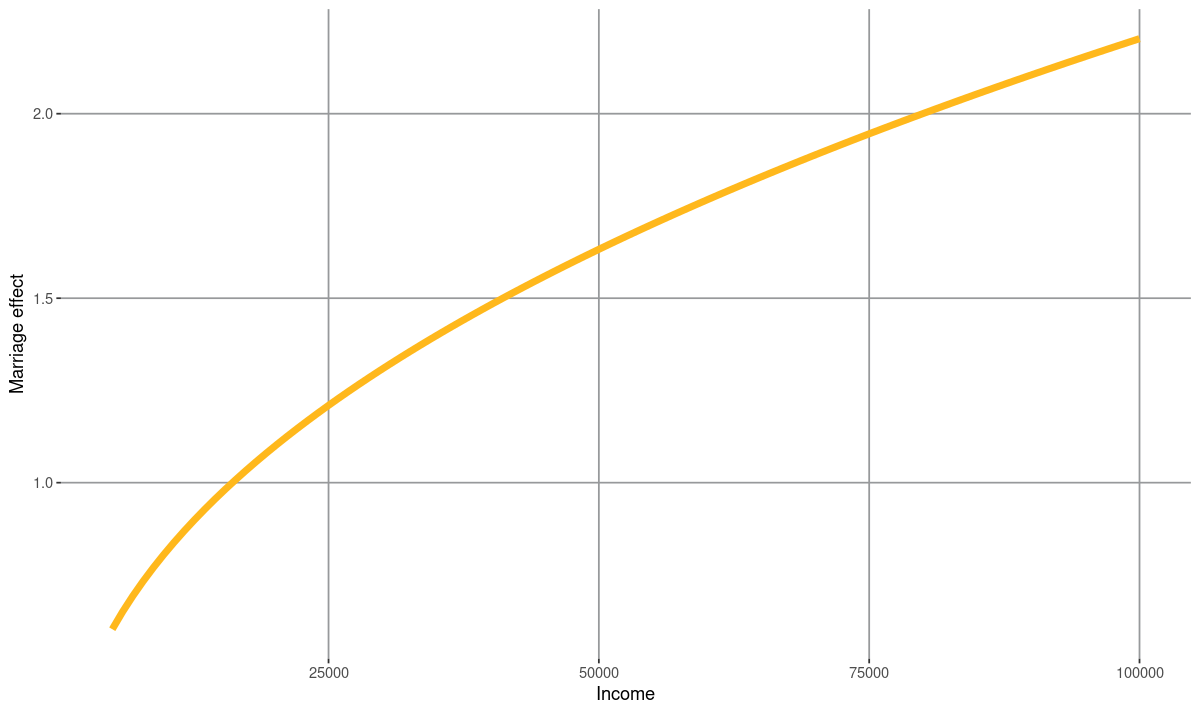

In [10]:
beta.hat <- coef(glm.output)
delta.lambda <- function(income) exp(beta.hat[1]+beta.hat[2]+beta.hat[3]*log(income))- )
# GRAPH IT
ggplot()+ Pitt.Theme+geom_function(fun=delta.lambda,color=Pitt.Gold,linewidth=2)+xlim(5000,100000)+labs(x="Income",y="Marriage effect")

Much of the non linearity is coming from the log, but switching to a log scale there is still some curvature remaining:

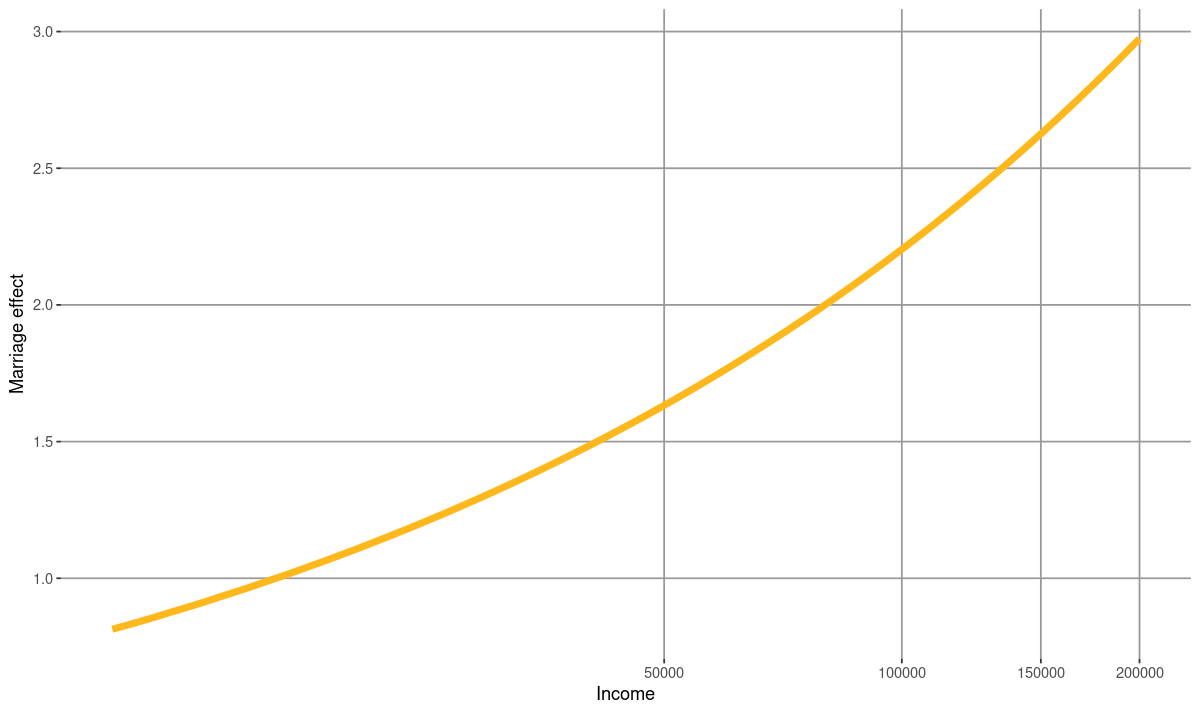

In [11]:
beta.hat <- coef(glm.output)
delta.lambda <- function(income) exp(beta.hat[1]+beta.hat[2]+beta.hat[3]*log(income))-exp(beta.hat[1]+beta.hat[3]*log(income))
ggplot()+ Pitt.Theme+geom_function(fun=delta.lambda,color=Pitt.Gold,linewidth=2)+labs(x="Income",y="Marriage effect")+ 
coord_trans(x='log2')+ xlim(10000,200000)

Obviously, this is entirely made up data, but the intuition is that the modeled marriage effect is a **multiplier** given by:
$$\exp(\beta_{\text{married}})$$

The level effect of marriage in this model will therefore depend on the other covariates (here income).

So now let's move on to examining some other probability families, and alternative link functions